# Example notebook

**Calling the libraries**

In [1]:
from getpass import getuser  # Libaray to copy things
from pathlib import Path  # Object oriented libary to deal with paths
from tempfile import (
    NamedTemporaryFile,
    TemporaryDirectory,
)  # Creating temporary Files/Dirs
from dask.utils import format_bytes
from distributed import (
    Client,
    progress,
    wait,
)  # Libaray to orchestrate distributed resources
from dask_jobqueue import SLURMCluster  # Setting up distributed memories via slurm
import numpy as np  # Pythons standard array library
import xarray as xr  # Libary to work with labeled n-dimensional data
import dask  # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import sys
import os
import warnings

warnings.filterwarnings(action="ignore")
import pandas as pd

dask.config.config.get("distributed").get("dashboard").update(
    {"link": "{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status"}
)

Establish the number of task to work with

In [2]:
ncpu = multiprocessing.cpu_count()
processes = False
nworker = 2
threads = ncpu // nworker
print(
    f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}"
)
client = Client(
    processes=processes,
    threads_per_worker=threads,
    n_workers=nworker,
    memory_limit="128GB",
)
client

Number of CPUs: 48, number of threads: 24, number of workers: 2, processes: False


Client Scheduler: inproc://136.172.50.55/32296/1 Dashboard: /user/m300876/preset//proxy/8787/status,Cluster Workers: 2 Cores: 48 Memory: 256.00 GB


_Selecting data_

In [3]:
# Define a global pattern to find the files
###cloud liquid water
glob_pattern_3d1 = "atm_2d_ml_2020"
## Define the paths of file 1 (dppp0016)
data_path1 = Path("/work/mh0287/k203123/GIT/icon-aes-dyw2/experiments/dpp0029")
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water
file_names1 = sorted([str(f) for f in data_path1.rglob(f"*{glob_pattern_3d1}*.nc")])[:]

_Open data set_

In [4]:
dset1 = xr.open_mfdataset(
    file_names1, combine="by_coords", chunks="auto", engine="netcdf4", parallel=True
)

In [5]:
dset1.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (ncells: 20971520, time: 466)
Coordinates:
  * time     (time) float64 2.02e+07 2.02e+07 2.02e+07 ... 2.02e+07 2.02e+07
Dimensions without coordinates: ncells
Data variables:
    ps       (time, ncells) float32 dask.array<chunksize=(4, 5242880), meta=np.ndarray>
    psl      (time, ncells) float32 dask.array<chunksize=(4, 5242880), meta=np.ndarray>
    rsdt     (time, ncells) float32 dask.array<chunksize=(4, 5242880), meta=np.ndarray>
    rsut     (time, ncells) float32 dask.array<chunksize=(4, 5242880), meta=np.ndarray>
    rsutcs   (time, ncells) float32 dask.array<chunksize=(4, 5242880), meta=np.ndarray>
    rlut     (time, ncells) float32 dask.array<chunksize=(4, 5242880), meta=np.ndarray>
    rlutcs   (time, ncells) float32 dask.array<chunksize=(4, 5242880), meta=np.ndarray>
    rsds     (time, ncells) float32 dask.array<chunksize=(4, 5242880), meta=np.ndarray>
    rsdscs   (time, ncells) float32 dask.array<chunksize=(4, 

In [6]:
format_bytes(dset1.nbytes)

'1.41 TB'

_Selecting variables_

In [7]:
dset_subset = dset1[["ts", "pr"]]

In [8]:
dset_subset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (ncells: 20971520, time: 466)
Coordinates:
  * time     (time) float64 2.02e+07 2.02e+07 2.02e+07 ... 2.02e+07 2.02e+07
Dimensions without coordinates: ncells
Data variables:
    ts       (time, ncells) float32 dask.array<chunksize=(4, 5242880), meta=np.ndarray>
    pr       (time, ncells) float32 dask.array<chunksize=(4, 5242880), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  15
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9
    title:                ICON simulation
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@432d202fb95b6d...
    history:              /work/mh0287/k203123/GIT/icon-aes-dyw2/bin/icon_dpp...
    r

In [9]:
format_bytes(dset_subset.nbytes)

'78.18 GB'

_Changing time_

In [10]:
dset_subset.time

<xarray.DataArray 'time' (time: 466)>
array([20200120.  , 20200120.25, 20200120.5 , ..., 20201229.  , 20201230.  ,
       20201231.  ])
Coordinates:
  * time     (time) float64 2.02e+07 2.02e+07 2.02e+07 ... 2.02e+07 2.02e+07
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T

In [11]:
time1 = pd.to_datetime(dset_subset.time.data, format="%Y%m%d")
hours = (dset_subset.time.values % 1) * 24
time2 = pd.to_datetime(hours, format="%H")
timenew = pd.to_datetime(pd.to_numeric(time2 - time2[0]) + pd.to_numeric(time1))

In [12]:
dset_subset["time"] = timenew

In [13]:
dset_subset.time

<xarray.DataArray 'time' (time: 466)>
array(['2020-01-20T00:00:00.000000000', '2020-01-20T06:00:00.000000000',
       '2020-01-20T12:00:00.000000000', ..., '2020-12-29T00:00:00.000000000',
       '2020-12-30T00:00:00.000000000', '2020-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T06:00:00 ... 2020-12-31

_Daily mean_

In [14]:
dset_daily = (
    dset_subset.sel(time=slice("2020-02-10", "2020-03-10"))
    .resample(time="1D", skipna=True)
    .mean()
)

In [15]:
dset_daily

<xarray.Dataset>
Dimensions:  (ncells: 20971520, time: 30)
Coordinates:
  * time     (time) datetime64[ns] 2020-02-10 2020-02-11 ... 2020-03-10
Dimensions without coordinates: ncells
Data variables:
    ts       (time, ncells) float32 dask.array<chunksize=(1, 5242880), meta=np.ndarray>
    pr       (time, ncells) float32 dask.array<chunksize=(1, 5242880), meta=np.ndarray>

In [16]:
prmean = dset_daily.pr.mean(dim="time").compute()

In [17]:
format_bytes(prmean.nbytes)

'83.89 MB'

In [18]:
tsmean = dset_daily.ts.mean(dim="time").compute()

In [19]:
format_bytes(tsmean.nbytes)

'83.89 MB'

_Assign coordinates_

In [20]:
####grid information
filegrid = "/pool/data/ICON/grids/public/mpim/0015/icon_grid_0015_R02B09_G.nc"
dsetgrid = xr.open_dataset(filegrid, chunks="auto", engine="netcdf4").rename(
    {"cell": "ncells"}
)

In [21]:
dsetgrid

<xarray.Dataset>
Dimensions:                         (cell_grf: 14, edge: 31457280, edge_grf: 24, max_chdom: 1, max_stored_decompositions: 4, nc: 2, ncells: 20971520, ne: 6, no: 4, nv: 3, two_grf: 2, vert_grf: 13, vertex: 10485762)
Coordinates:
    clon                            (ncells) float64 dask.array<chunksize=(10485760,), meta=np.ndarray>
    clat                            (ncells) float64 dask.array<chunksize=(10485760,), meta=np.ndarray>
    vlon                            (vertex) float64 dask.array<chunksize=(10485762,), meta=np.ndarray>
    vlat                            (vertex) float64 dask.array<chunksize=(10485762,), meta=np.ndarray>
    elon                            (edge) float64 dask.array<chunksize=(15728640,), meta=np.ndarray>
    elat                            (edge) float64 dask.array<chunksize=(15728640,), meta=np.ndarray>
Dimensions without coordinates: cell_grf, edge, edge_grf, max_chdom, max_stored_decompositions, nc, ncells, ne, no, nv, two_grf, vert_grf, vertex
Data variables:
    clon_vertices                   (ncells, nv) float64 dask.array<chunksize=(5242880, 3), meta=np.ndarray>
    clat_vertices                   (ncells, nv) float64 dask.array<chunksize=(5242880, 3), meta=np.ndarray>
    vlon_vertices                   (vertex, ne) float64 dask.array<chunksize=(1747627, 6), meta=np.ndarray>
    vlat_vertices                   (vertex, ne) float64 dask.array<chunksize=(1747627, 6), meta=np.ndarray>
    elon_vertices                   (edge, no) float64 dask.array<chunksize=(3932160, 4), meta=np.ndarray>
    elat_vertices                   (edge, no) float64 dask.array<chunksize=(3932160, 4), meta=np.ndarray>
    ifs2icon_cell_grid              (ncells) float64 dask.array<chunksize=(10485760,), meta=np.ndarray>
    ifs2icon_edge_grid              (edge) float64 dask.array<chunksize=(15728640,), meta=np.ndarray>
    ifs2icon_vertex_grid            (vertex) float64 dask.array<chunksize=(10485762,), meta=np.ndarray>
    cell_area                       (ncells) float64 dask.array<chunksize=(10485760,), meta=np.ndarray>
    dual_area                       (vertex) float64 dask.array<chunksize=(10485762,), meta=np.ndarray>
    phys_cell_id                    (ncells) int32 dask.array<chunksize=(20971520,), meta=np.ndarray>
    phys_edge_id                    (edge) int32 dask.array<chunksize=(31457280,), meta=np.ndarray>
    lon_cell_centre                 (ncells) float64 dask.array<chunksize=(10485760,), meta=np.ndarray>
    lat_cell_centre                 (ncells) float64 dask.array<chunksize=(10485760,), meta=np.ndarray>
    lat_cell_barycenter             (ncells) float64 dask.array<chunksize=(10485760,), meta=np.ndarray>
    lon_cell_barycenter             (ncells) float64 dask.array<chunksize=(10485760,), meta=np.ndarray>
    longitude_vertices              (vertex) float64 dask.array<chunksize=(10485762,), meta=np.ndarray>
    latitude_vertices               (vertex) float64 dask.array<chunksize=(10485762,), meta=np.ndarray>
    lon_edge_centre                 (edge) float64 dask.array<chunksize=(15728640,), meta=np.ndarray>
    lat_edge_centre                 (edge) float64 dask.array<chunksize=(15728640,), meta=np.ndarray>
    edge_of_cell                    (nv, ncells) int32 dask.array<chunksize=(3, 10485760), meta=np.ndarray>
    vertex_of_cell                  (nv, ncells) int32 dask.array<chunksize=(3, 10485760), meta=np.ndarray>
    adjacent_cell_of_edge           (nc, edge) int32 dask.array<chunksize=(2, 15728640), meta=np.ndarray>
    edge_vertices                   (nc, edge) int32 dask.array<chunksize=(2, 15728640), meta=np.ndarray>
    cells_of_vertex                 (ne, vertex) int32 dask.array<chunksize=(6, 5242881), meta=np.ndarray>
    edges_of_vertex                 (ne, vertex) int32 dask.array<chunksize=(6, 5242881), meta=np.ndarray>
    vertices_of_vertex              (ne, vertex) int32 dask.array<chunksize=(6, 5242881), meta=np.ndarray>
    cell_area_p           

_Assing lat and lot to the output file_

In [22]:
prmean = prmean.assign_coords(
    clon=("ncells", dsetgrid.clon * 180 / np.pi),
    clat=("ncells", dsetgrid.clat * 180 / np.pi),
)

In [23]:
prmean.clon

<xarray.DataArray 'clon' (ncells: 20971520)>
array([73.        , 73.05645347, 72.94354653, ..., 76.49297292,
       76.54481611, 76.4503828 ])
Coordinates:
    clon     (ncells) float64 73.0 73.06 72.94 73.0 ... 76.5 76.49 76.54 76.45
    clat     (ncells) float64 52.61 52.63 52.63 52.57 ... -45.17 -45.23 -45.23
Dimensions without coordinates: ncells

In [24]:
tsmean = prmean.assign_coords(
    clon=("ncells", dsetgrid.clon * 180 / np.pi),
    clat=("ncells", dsetgrid.clat * 180 / np.pi),
)

In [25]:
tsmean.clat

<xarray.DataArray 'clat' (ncells: 20971520)>
array([ 52.60689104,  52.62663022,  52.62663022, ..., -45.17171677,
       -45.23138792, -45.23383705])
Coordinates:
    clon     (ncells) float64 73.0 73.06 72.94 73.0 ... 76.5 76.49 76.54 76.45
    clat     (ncells) float64 52.61 52.63 52.63 52.57 ... -45.17 -45.23 -45.23
Dimensions without coordinates: ncells

_Plotting_

In [26]:
from cartopy import crs as ccrs  # Cartography library
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib import pyplot as plt  # Standard Plotting library
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

_Using native grid_

Text(0, 0.5, '')

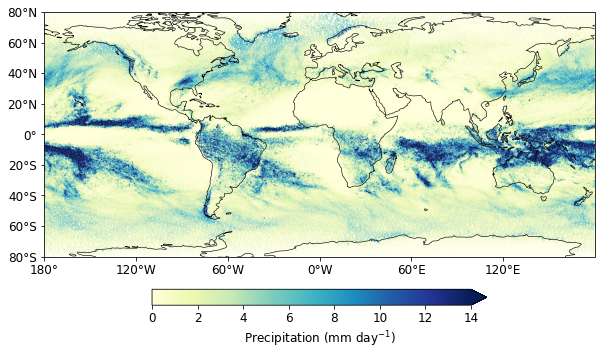

In [27]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
cs1 = plt.scatter(
    prmean.clon[::100],
    prmean.clat[::100],
    s=0.1,
    c=prmean[::100] * 24 * 3600,
    vmin=0,
    vmax=14,
    cmap="YlGnBu",
    transform=ccrs.PlateCarree(),
)
cb1 = plt.colorbar(cs1, extend="max", orientation="horizontal", shrink=0.6, pad=0.1)
cb1.ax.set_xlabel("Precipitation (mm day$^{-1}$)", fontsize=12)
cb1.ax.tick_params(labelsize=12)
ax.coastlines(resolution="110m", linewidth=0.6)
ax.set_extent([-180, 179.9, -80, 80], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-80, 81, 20), crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-180, 179, 60), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=12)
ax.set_xlabel(None)
ax.set_ylabel(None)

_Assign land_sea mask_

In [28]:
land_sea_mask = dsetgrid.cell_sea_land_mask.persist()

In [29]:
prmean["land_sea_mask"] = (("ncells"), land_sea_mask)

In [30]:
prmean_land = prmean.where(prmean.land_sea_mask > 0)

Text(0, 0.5, '')

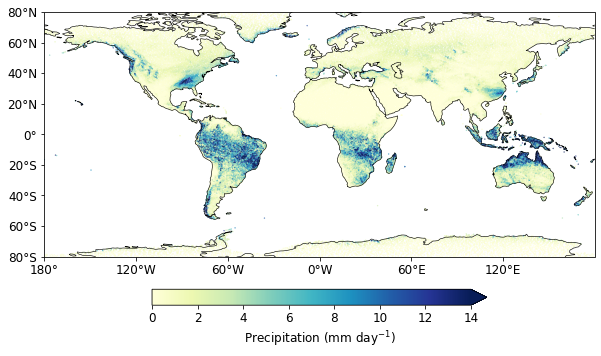

In [31]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
cs1 = plt.scatter(
    prmean_land.clon[::100],
    prmean_land.clat[::100],
    s=0.1,
    c=prmean_land[::100] * 24 * 3600,
    vmin=0,
    vmax=14,
    cmap="YlGnBu",
    transform=ccrs.PlateCarree(),
)
cb1 = plt.colorbar(cs1, extend="max", orientation="horizontal", shrink=0.6, pad=0.1)
cb1.ax.set_xlabel("Precipitation (mm day$^{-1}$)", fontsize=12)
cb1.ax.tick_params(labelsize=12)
ax.coastlines(resolution="110m", linewidth=0.6)
ax.set_extent([-180, 179.9, -80, 80], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-80, 81, 20), crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-180, 179, 60), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=12)
ax.set_xlabel(None)
ax.set_ylabel(None)

_Regridding_

In [32]:
def get_griddes(y_res, x_res, x_first=-180, y_first=-90):
    """Create a description for a regular global grid at given x, y resolution."""

    xsize = 360 / x_res
    ysize = 180 / y_res
    xfirst = -180 + x_res / 2
    yfirst = -90 + x_res / 2

    return f"""
#
# gridID 1
#
gridtype  = lonlat
gridsize  = {int(xsize * ysize)}
xsize     = {int(xsize)}
ysize     = {int(ysize)}
xname     = lon
xlongname = "longitude"
xunits    = "degrees_east"
yname     = lat
ylongname = "latitude"
yunits    = "degrees_north"
xfirst    = {xfirst}
xinc      = {x_res}
yfirst    = {yfirst}
yinc      = {y_res}
 
 
    """

In [33]:
@dask.delayed
def gen_dis(dataset, xres, yres, gridfile):
    """Create a distance weights using cdo."""
    scratch_dir = (
        Path("/scratch") / getuser()[0] / getuser() / Path("data")
    )  # Define the users scratch dir
    with TemporaryDirectory(dir=scratch_dir, prefix="Weights_") as td:
        in_file = Path(td) / "in_file.nc"
        weightfile = Path(td) / "weight_file.nc"
        griddes = Path(td) / "griddes.txt"
        with griddes.open("w") as f:
            f.write(get_griddes(xres, yres))
        dataset.to_netcdf(in_file, mode="w")  # Write the file to a temorary netcdf file
        cmd = (
            "cdo",
            "-O",
            f"gendis,{griddes}",
            f"-setgrid,{gridfile}",
            str(in_file),
            str(weightfile),
        )
        run_cmd(cmd)
        df = xr.open_dataset(weightfile).load()
        wait(df)
        return df


def run_cmd(cmd, path_extra=Path(sys.exec_prefix) / "bin"):
    """Run a bash command."""
    env_extra = os.environ.copy()
    env_extra["PATH"] = str(path_extra) + ":" + env_extra["PATH"]
    status = run(cmd, check=False, stderr=PIPE, stdout=PIPE, env=env_extra)
    if status.returncode != 0:
        error = f"""{' '.join(cmd)}: {status.stderr.decode('utf-8')}"""
        raise RuntimeError(f"{error}")
    return status.stdout.decode("utf-8")

In [34]:
@dask.delayed
def remap(dataset, x_res, y_res, weights, gridfile):
    """Perform a weighted remapping.

    Parameters
    ==========

    dataset : xarray.dataset
        The dataset that will be regridded
    griddes : Path, str
        Path to the grid description file
    weights : xarray.dataset
        Distance weights

    Returns
    =======
    xarray.dataset : Remapped dataset
    """
    if isinstance(dataset, xr.DataArray):
        # If a dataArray is given create a dataset
        dataset = xr.Dataset(data_vars={dataset.name: dataset})
    scratch_dir = (
        Path("/scratch") / getuser()[0] / getuser() / Path("data")
    )  # Define the users scratch dir
    with TemporaryDirectory(dir=scratch_dir, prefix="Remap_") as td:
        infile = Path(td) / "input_file.nc"
        weightfile = Path(td) / "weight_file.nc"
        griddes = Path(td) / "griddes.txt"
        outfile = Path(td) / "remaped_file.nc"
        with griddes.open("w") as f:
            f.write(get_griddes(x_res, y_res))
        dataset.to_netcdf(infile, mode="w")  # Write the file to a temorary netcdf file
        weights.to_netcdf(weightfile, mode="w")
        cmd = (
            "cdo",
            "-O",
            f"remap,{griddes},{weightfile}",
            f"-setgrid,{gridfile}",
            str(infile),
            str(outfile),
        )
        run_cmd(cmd)
        return xr.open_dataset(outfile).load()

_Create weighted grids_

In [35]:
weights_future = gen_dis(prmean, 0.1, 0.1, filegrid)

_Remapping grids_

In [36]:
####File 1
remap_precip = remap(prmean, 0.1, 0.1, weights_future, filegrid)

In [37]:
remap_jobs = dask.persist(remap_precip)

In [38]:
progress(remap_jobs, notebook=False)

In [39]:
precip = dask.compute(remap_precip)[0]

In [40]:
precip.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (lat: 1800, lon: 3600)
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    pr       (lat, lon) float32 1.695e-06 1.695e-06 ... 5.842e-06 5.842e-06
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Sep 08 11:02:08 2021: cdo -O remap,/scratch/m/m300876/d...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...>

Text(0, 0.5, '')

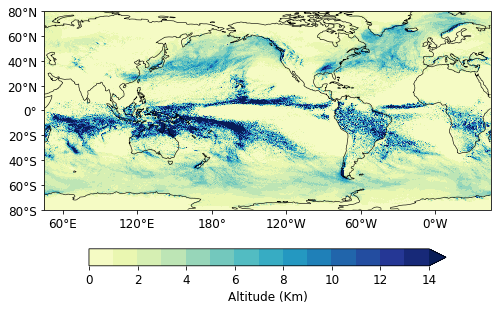

In [41]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=225))
plot = (precip.pr * 24 * 3600).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="YlGnBu",
    levels=np.linspace(0, 14, 15),
    vmin=0,
    vmax=14,
    extend="both",
    add_colorbar=False,
)
cb1 = plt.colorbar(plot, extend="max", orientation="horizontal", shrink=0.8, pad=0.12)
cb1.ax.set_xlabel("Altitude (Km)", fontsize=12)
cb1.ax.tick_params(labelsize=12)
ax.coastlines(resolution="110m", linewidth=0.6)
ax.set_extent([-180, 179.9, -80, 80], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-80, 81, 20), crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-180, 179, 60), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=12)
ax.set_xlabel(None)
ax.set_ylabel(None)

_Save file_

In [42]:
scratch_dir = (
    Path("/scratch") / getuser()[0] / getuser()
)  # if it has not been defined before
out_file = Path(scratch_dir) / "OutfileName.nc"
prmean.to_netcdf(out_file, mode="w")

_Load file_

In [43]:
loadset = xr.open_dataset(out_file, chunks="auto", engine="netcdf4")

In [45]:
loadset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:        (ncells: 20971520)
Coordinates:
    clon           (ncells) float64 dask.array<chunksize=(10485760,), meta=np.ndarray>
    clat           (ncells) float64 dask.array<chunksize=(10485760,), meta=np.ndarray>
    land_sea_mask  (ncells) int32 dask.array<chunksize=(20971520,), meta=np.ndarray>
Dimensions without coordinates: ncells
Data variables:
    pr             (ncells) float32 dask.array<chunksize=(20971520,), meta=np.ndarray>>